In [33]:
#import torch
import pandas as pd
import numpy as np
import json
import os
import sys
from sklearn.metrics import f1_score
import h3pandas
import torch
import h3
from sklearn.metrics import precision_recall_curve
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt

sys.path.append('../')
import datasets
import models
import utils
import setup

from sklearn.linear_model import LogisticRegression


get training data

In [7]:
train_params = {}

train_params['experiment_name'] = 'demo' # This will be the name of the directory where results for this run are saved.
train_params['species_set'] = 'all'
train_params['hard_cap_num_per_class'] = 1000
train_params['num_aux_species'] = 0
train_params['input_enc'] = 'sin_cos'
train_params['loss'] = 'an_full'

In [8]:
params = setup.get_default_params_train(train_params)

In [9]:
train_dataset = datasets.get_train_data(params)


Loading  ../data/train/geo_prior_train.csv
Number of unique classes 47375
subsampling (up to) 1000 per class for the training set
final training set size: 15132683


In [10]:
train_df = pd.DataFrame(train_dataset.locs, columns=['lng','lat'])
train_df['lng'] = train_df['lng']*180
train_df['lat'] = train_df['lat']*90
train_df['label'] = train_dataset.labels

In [11]:
train_df = train_df#[:100000]

In [100]:
h3_resolution = 5
train_df_h3 = train_df.h3.geo_to_h3(h3_resolution)
all_spatial_grid_counts = train_df_h3.index.value_counts()
presence_absence = pd.DataFrame({
    "background": all_spatial_grid_counts,
})
presence_absence = presence_absence.fillna(0)

In [101]:
resolution = h3_resolution
area = h3.hex_area(resolution)

In [102]:
# load model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_params = torch.load('../pretrained_models/model_an_full_input_enc_sin_cos_hard_cap_num_per_class_1000.pt', map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [103]:
if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

In [104]:
#load reference from iucn
with open(os.path.join('../data/eval/iucn/', 'iucn_res_5.json'), 'r') as f:
            data = json.load(f)
species_ids = list((data['taxa_presence'].keys()))

In [105]:
def generate_h3_cells_atRes(resolution=4):
    h3_cells = list(h3.get_res0_indexes())
    h3_atRes_cells = set()
    for cell in h3_cells:
        h3_atRes_cells = h3_atRes_cells.union(h3.h3_to_children(cell, resolution))
    return list(h3_atRes_cells)

In [106]:
#generate gdfk table
h3_atRes_cells = generate_h3_cells_atRes(h3_resolution)
gdfk = pd.DataFrame(index=h3_atRes_cells).h3.h3_to_geo()
gdfk["lng"] = gdfk["geometry"].x
gdfk["lat"] = gdfk["geometry"].y
_ = gdfk.pop("geometry")
gdfk = gdfk.rename_axis('h3index')


In [107]:
obs_locs = np.array(gdfk[['lng', 'lat']].values, dtype=np.float32)
obs_locs = torch.from_numpy(obs_locs).to('cpu')
loc_feat = enc.encode(obs_locs)

In [108]:
classes_of_interest = torch.zeros(len(species_ids), dtype=torch.int64)
taxa_ids = torch.zeros(len(species_ids), dtype=torch.int64)
for tt_id, tt in enumerate(species_ids):
    class_of_interest = np.array([train_params['params']['class_to_taxa'].index(int(tt))])
    classes_of_interest[tt_id] = torch.from_numpy(class_of_interest)
    

In [109]:
with torch.no_grad():
    loc_emb = model(loc_feat, return_feats=True)
    wt = model.class_emb.weight[classes_of_interest, :]

In [110]:
def fscore_and_thres(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    p1 = (2 * precision * recall)
    p2 = (precision + recall)
    out = np.zeros( (len(p1)) )
    fscore = np.divide(p1,p2, out=out, where=p2!=0)
    index = np.argmax(fscore)
    thres = thresholds[index]
    max_fscore = fscore[index]
    return max_fscore, thres

In [111]:
output = []
for class_index, class_id in enumerate(classes_of_interest):
    wt_1 = wt[class_index,:]
    raw_preds = torch.matmul(loc_emb, wt_1)
    preds = torch.sigmoid(raw_preds).cpu().numpy()
    gdfk["pred"] = preds
    gdfk["raw_preds"] = raw_preds

    target_spatial_grid_counts = train_df_h3[train_df_h3.label==class_id.item()].index.value_counts()

    presence_absence["forground"] = target_spatial_grid_counts
    presence_absence["predictions"] = gdfk["pred"]
    presence_absence["raw_preds"] = gdfk["raw_preds"]
    presence_absence.forground = presence_absence.forground.fillna(0)
    yield_cutoff = np.percentile((presence_absence["background"]/presence_absence["forground"])[presence_absence["forground"]>0], 95)
    absences = presence_absence[(presence_absence["forground"]==0) & (presence_absence["background"] > yield_cutoff)][["predictions", "raw_preds"]]
    presences = presence_absence[(presence_absence["forground"]>0)][["predictions", "raw_preds"]]
    df_x = pd.DataFrame({'predictions': presences['predictions'],'raw_preds': presences['raw_preds'], 'test': 1})
    df_y = pd.DataFrame({'predictions': absences['predictions'],'raw_preds': absences['raw_preds'], 'test': 0})
    for_thres = pd.concat([df_x, df_y], ignore_index=False)

    ###calibration
    logistic_regression = LogisticRegression()
    logistic_regression.fit(for_thres.predictions.values.reshape(-1, 1), for_thres.test.values)  # true_labels are the true labels corresponding to raw_predictions
    calibrated_probs = logistic_regression.predict_proba(for_thres.predictions.values.reshape(-1, 1))[:, 1]

    ###eval
    taxa = train_dataset.class_to_taxa[class_id.item()]
    species_locs = data['taxa_presence'].get(str(taxa))
    y_test = np.zeros(preds.shape, int)
    y_test[species_locs] = 1

    ###uncalibrated score
    u_max_fscore, u_thres = fscore_and_thres(y_test, preds)

    ###calibrated score
    c_max_fscore, c_thres = fscore_and_thres(y_test, calibrated_probs)
    
    row = {
        "taxon_id": taxa,
        "uncalibrated_thres": u_thres,
        "uncalibrated_fscore": u_max_fscore,
        "calibrated_thres": c_thres,
        "calibrated_fscore": c_max_fscore,
    }
    row_dict = dict(row)
    output.append(row_dict)

    if(class_index%100==0):
            print(class_index)
    if class_index == 0: break

output_pd = pd.DataFrame(output)
    

ValueError: Found input variables with inconsistent numbers of samples: [2016842, 4714]

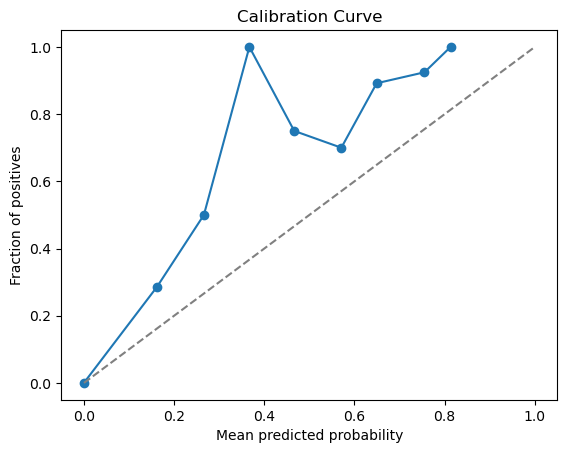

In [93]:
# before calibration
from sklearn.calibration import calibration_curve
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(for_thres['test'], for_thres['predictions'], n_bins=10, strategy='uniform')

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.show()

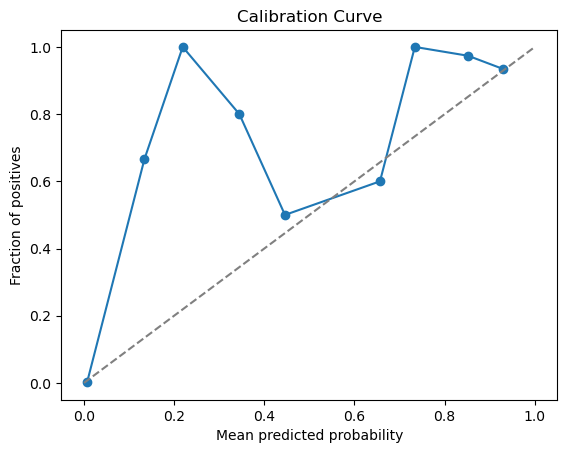

In [94]:
# after calibration
from sklearn.calibration import calibration_curve
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(for_thres['test'], calibrated_probs, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.show()